# Tracking particles in brightfield

**TL;DR** We developed a new method to more accurately track colloidal particles in bright field images that do not resemble Gaussian features.

The standard `locate` function in `trackpy` finds features by determining local maxima of intensity, thereby assuming the particles that need to be tracked have a Gaussian intensity distribution with a maximum in the center. While this is usually true for fluorescent particles, particles in bright field mode show a different intensity profile (see example images in this notebook).

Because the intensity profile is usually different from a Gaussian in bright field mode, the `locate` function fails to accurately find the center of the particle. We have developed a new method that uses the edge of the particle to more accurately refine the position of the center of the particle as detected by the standard `locate` function.

**Citing this work**
The algorithm we'll use is described in the following paper:
"Colloid supported lipid bilayers for self-assembly", M. Rinaldin, R.W. Verweij, I. Chakrabory, D.J. Kraft, Soft Matter (2019) [https://doi.org/10.1039/c8sm01661e](https://doi.org/10.1039/c8sm01661e). It is implemented in `trackpy` as `locate_brightfield_ring`. If you're using this code in your work, please cite both the paper and the appropriate `trackpy` version.

## Preliminary imports

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

We also might want to use scientific Python libraries. Finally, we'll import ``trackpy`` itself and its sister project, `pims`.

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import xarray as xr

import pims
from pims import ND2_Reader
import trackpy as tp

## Step 1: Read the Data

### Opening images or video

We open the files with `pims`:

In [3]:
frames = ND2_Reader('Z:\\Hannah - vimentin networks\\m04\\210624_Vimentin_m04_p06_B_.nd2')

C:\Users\rmcgorty\Anaconda3\lib\site-packages\pims\api.py:119: UserWarning: 'ND2_Reader' has been renamed to 'ND2Reader_SDK' and will beremoved in future pims versions. Please use the new name, or try out the pure-Python one named `ND2Reader`.
  warn("'ND2_Reader' has been renamed to 'ND2Reader_SDK' and will be"
C:\Users\rmcgorty\Anaconda3\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


In [4]:
micron_per_pixel = 0.13
feature_diameter = 1.0 # um
radius = int(np.round(feature_diameter/2.0/micron_per_pixel))
if radius % 2 == 0:
    radius += 1
print('Using a radius of {:d} px'.format(radius))
frames

Using a radius of 5 px


<FramesSequenceND>
Axes: 3
Axis 'x' size: 512
Axis 'y' size: 512
Axis 't' size: 5000
Pixel Datatype: <class 'numpy.uint16'>

These are colloidal particles diffusing in quasi-2D on a substrate. The images are cropped to focus on just five particles for 50 frames (approximately 7 seconds). Let's have a look a the first frame:

Frame([[39260, 39374, 40229, ..., 37903, 37909, 38988],
       [39459, 39630, 39936, ..., 38662, 38605, 38588],
       [39706, 39632, 39498, ..., 38525, 38645, 38446],
       ...,
       [40208, 40291, 40170, ..., 39257, 39159, 38757],
       [39883, 39684, 39986, ..., 39123, 39072, 39256],
       [40308, 40765, 40809, ..., 38619, 38683, 39316]], dtype=uint16)
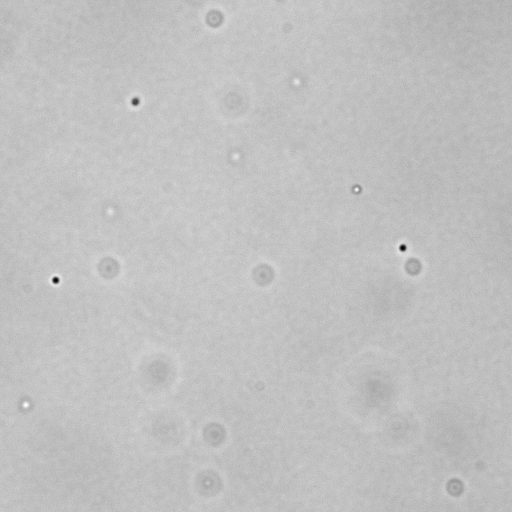

In [5]:
frames[0]

## Step 2: Locate Features

### Using the locate function

First, we'll try the standard `locate` function to find the particle positions:

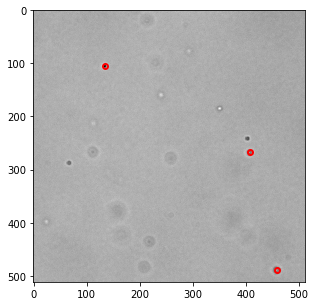

In [6]:
# we use a slightly larger radius
#f_locate = tp.locate(frames[100], 9, minmass=100000, invert=True)
f_locate = tp.locate(frames[100], 21, minmass=400000, invert=True)
tp.annotate(f_locate, frames[100], plot_style={'markersize': radius});

In [7]:
#f = tp.batch(frames[:5000], 9, minmass=100000, invert=True, processes=1)
f = tp.batch(frames[:5000], 21, minmass=400000, invert=True, processes=1)

Frame 4999: 2 features


In [8]:
t = tp.link(f, 5, memory=3)

Frame 4999: 2 trajectories present.


In [10]:
t.to_pickle("./210624_Vimentin_m04_p06_B_TRAJECTORY_NEW.pkl")

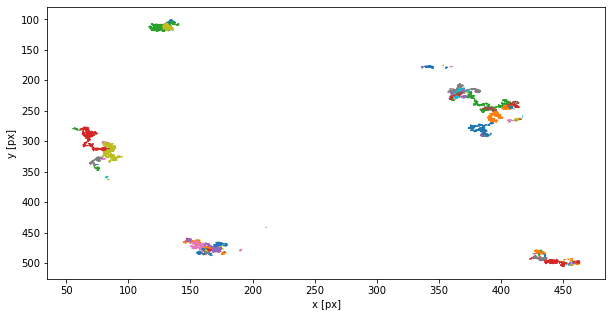

In [9]:
plt.figure()
tp.plot_traj(t);

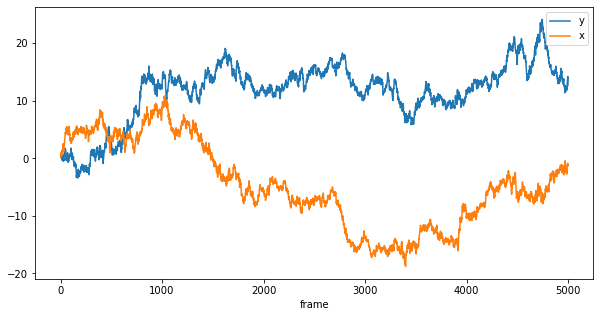

In [10]:
d = tp.compute_drift(t)
d.plot()
plt.show()

In [11]:
tm = tp.subtract_drift(t.copy(), d)

In [12]:
t.to_pickle("./210624_Vimentin_m04_p06_B_TRAJECTORY.pkl")

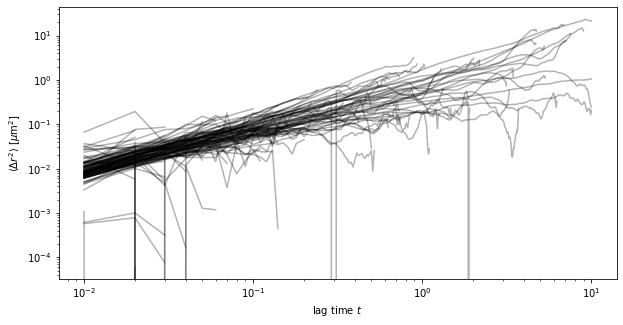

In [13]:
im = tp.imsd(t, 0.13, 99.92, max_lagtime=1000)
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [14]:
imx = tp.imsd(t, 0.13, 99.92, max_lagtime=1000, statistic='<x>')
imy = tp.imsd(t, 0.13, 99.92, max_lagtime=1000, statistic='<y>')

In [15]:
isf = np.zeros((1000),dtype=np.complex128)
isf_std = np.zeros_like(isf)
isf_stderr = np.zeros_like(isf)
q = 6*np.sqrt(2)
count=0

for i in range(1000):
    count=0
    temp = []
    for particle in imx.keys():
        if not np.isnan(imx[particle].values[i]):
            #temp.append(np.exp(-1j*q*np.sqrt(im[particle].values[i])))
            temp.append(np.exp(-1j*q*imx[particle].values[i]))
            temp.append(np.exp(-1j*q*imy[particle].values[i]))
            temp.append(np.exp(-1j*q*np.sqrt(1./2)*imx[particle].values[i])*np.exp(-1j*q*np.sqrt(1./2)*imy[particle].values[i]))
    isf[i] = np.mean(temp)
    isf_std[i] = np.std(temp)
    isf_stderr[i] = np.std(temp)/np.sqrt(len(temp)/3)
    #isf[i] = isf[i]/count

C:\Users\rmcgorty\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\rmcgorty\Anaconda3\lib\site-packages\numpy\ma\core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


<ErrorbarContainer object of 3 artists>

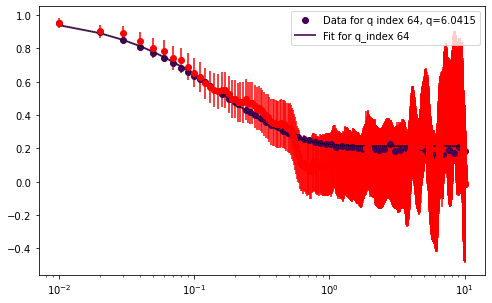

In [16]:
fit_saved_dir = "C:/Users/rmcgorty/Dropbox/ManuscriptsInProgress/DDM of cytoskeleton - JoVE/Data/"
fit04_06_A = xr.open_dataset(fit_saved_dir+"ddm_fits/fit04_06_A.nc")
fit04_06_A1 = xr.open_dataset(fit_saved_dir+"ddm_fits/fit04_06_A1.nc")
fit04_06_B = xr.open_dataset(fit_saved_dir+"ddm_fits/fit04_06_B.nc")
fit04_06_B1 = xr.open_dataset(fit_saved_dir+"ddm_fits/fit04_06_B1.nc")

cmap = plt.get_cmap("viridis") 

fig_width = 8
markersize = 6 #was 1
fig, ax = plt.subplots(nrows=1, figsize=(fig_width,fig_width/1.618))
data = 0.25 * (fit04_06_A.isf_data + fit04_06_A1.isf_data + fit04_06_B.isf_data + fit04_06_B1.isf_data)
theory = 0.25 * (fit04_06_A.theory + fit04_06_A1.theory + fit04_06_B.theory + fit04_06_B1.theory)
times = fit04_06_A.lagtime
q = fit04_06_A.q    
xlabel_str = "Lag time (s)"
ylabel_str = "ISF"

q_index_to_plot = np.arange(12,100,7)
clrs = np.linspace(0,1,len(q_index_to_plot))
for i,qv in enumerate([64]):
    plt_color = cmap(clrs[i])
    qv = int(qv)

    ax.semilogx(times, data[:,qv], 'o', ms=markersize, color=plt_color, label="Data for q index %i, q=%.4f" % (qv, q[qv]))
    ax.semilogx(times, theory[:,qv], '-', color=plt_color, lw=2, alpha=0.8, label="Fit for q_index %i" % qv)
    ax.semilogx(times, theory[:,qv], color='k', linestyle=(0, (1, 1)), lw=1)

plt.legend()

plt.semilogx(im.index, isf, 'ro')
plt.errorbar(im.index, isf, yerr=isf_stderr, fmt='none', color='r')

In [17]:
em = tp.emsd(tm, 0.13, 99.92, max_lagtime=1000)


Text(0.5, 1.0, 'm03\\210624_Vimentin_m03_p06_B_')

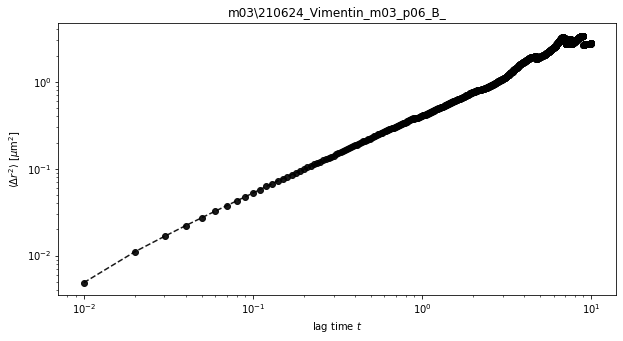

In [18]:
fig, ax = plt.subplots()
ax.loglog(em.index, em, '--ko', alpha=0.9)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.title("m03\\210624_Vimentin_m03_p06_B_")
#ax.plot(em.index, (em.index**0.32) * 0.032, '-b')
#plt.axhline(y=0.024)

In [19]:
em.to_pickle("./210624_Vimentin_m04_p06_B_trackpy.pkl")

In [34]:
tp.emsd?

All particle trajectories seem to be tracked. Let's zoom in a bit more to verify this:

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

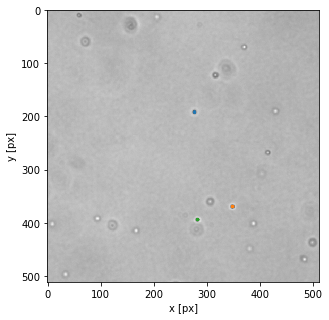

In [46]:
plt.figure()
background = np.mean(frames[0:10], axis=0)
tp.plot_traj(tm, superimpose=background, ax=plt.gca(), plot_style={'linewidth': 2})
#plt.ylim(0, 150)
#plt.xlim(200, 450);

Alternatively, you can use [Pimsviewer](https://github.com/soft-matter/pimsviewer#example-03-annotating-features-on-a-video) to overlay the positions on your video to check if the tracking has succeeded. Now you can analyse your data using the accurate center positions of the particles.

# About this work

This tutorial was written by Ruben Verweij, as part of his PhD thesis in Daniela Kraft’s group at the Huygens-Kamerlingh-Onnes laboratory, Institute of Physics, Leiden University, The Netherlands. This work was supported by the Netherlands Organisation for Scientific Research (NWO/OCW) and the European Research Council (ERC).

**Citing this work**
The algorithm is described in the following paper:
"Colloid supported lipid bilayers for self-assembly", M. Rinaldin, R.W. Verweij, I. Chakrabory, D.J. Kraft, Soft Matter (2019) [https://doi.org/10.1039/c8sm01661e](https://doi.org/10.1039/c8sm01661e). It is implemented in `trackpy` as `locate_brightfield_ring`. If you're using this code in your work, please cite both the paper and the appropriate `trackpy` version.